In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df_initial = pd.read_csv('loldata_diamondonly.csv')

In [4]:
df_initial.head()

,date,popularity,winrate,banrate,name,release,changes
0,1.394525e+09,4.38,51.74,0.44,aatrox,1.370045e+09,nochange
1,1.394525e+09,5.29,51.43,0.29,ryze,1.233446e+09,nochange
2,1.394525e+09,1.19,46.38,NaN,sejuani,1.325376e+09,nochange
3,1.394525e+09,1.40,45.86,0.15,diana,1.343779e+09,buff
4,1.394525e+09,3.54,52.30,0.73,shaco,1.254355e+09,nochange


# Create Features

In [5]:
# Time since released
df_initial['tsr'] = df_initial.apply(lambda x: x.date-x.release, axis=1)

In [6]:
# df_release = df.groupby('name')['release'].mean()
# df_release.to_csv('lolrelease.csv')

In [7]:
# Change only
def haschange(row):
    if row.changes == 'buff' or row.changes == 'nerf':
        return True
    else:
        return False

df_initial['haschange'] = df_initial.apply(haschange, axis=1)
df_initial.head()

,date,popularity,winrate,banrate,name,release,changes,tsr,haschange
0,1.394525e+09,4.38,51.74,0.44,aatrox,1.370045e+09,nochange,2.448053e+07,False
1,1.394525e+09,5.29,51.43,0.29,ryze,1.233446e+09,nochange,1.610789e+08,False
2,1.394525e+09,1.19,46.38,NaN,sejuani,1.325376e+09,nochange,6.914933e+07,False
3,1.394525e+09,1.40,45.86,0.15,diana,1.343779e+09,buff,5.074613e+07,True
4,1.394525e+09,3.54,52.30,0.73,shaco,1.254355e+09,nochange,1.401701e+08,False


In [8]:
# Time since last patch change (max 25)

# Velocity

df = pd.DataFrame(columns=['date', 'popularity', 'winrate', 'banrate',
                          'name', 'release', 'changes', 'tsr', 
                          'haschange', 'ts_nerf', 'ts_buff'])

for champ in df_initial['name'].unique():
    df_temp = df_initial.loc[(df_initial['name']==champ)].copy()

    df_temp.reset_index(inplace=True, drop=True)
    buffs = df_temp[df_temp['changes']=='buff'].index
    nerfs = df_temp[df_temp['changes']=='nerf'].index

    for index in range(0, len(df_temp)):
        if any(((index - buffs) > 0) & ((index - buffs) <= 25)):
            df_temp.loc[index,'ts_nerf'] = min(i for i in (index - buffs) if i > 0)
        else:
            df_temp.loc[index,'ts_nerf'] = 25

        if any(((index - nerfs) > 0) & ((index - nerfs) <= 25)):
            df_temp.loc[index, 'ts_buff'] = min(i for i in (index - nerfs) if i > 0)
        else:
            df_temp.loc[index, 'ts_buff'] = 25  
    
    df_temp['vpop'] = df_temp.popularity - df_temp.popularity.shift(1)
    df_temp['vwr'] = df_temp.winrate - df_temp.winrate.shift(1)
    df_temp['vbr'] = df_temp.banrate - df_temp.banrate.shift(1)
    
    df = df.append(df_temp)

In [131]:
nerfs = pd.read_csv('reddit_nerfs.csv')
buffs = pd.read_csv(open('reddit_buffs.csv','rU'), encoding='utf-8', engine='c')


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 'U' mode is deprecated
  from ipykernel import kernelapp as app


In [133]:
df2 = pd.DataFrame(columns=['date', 'popularity', 'winrate', 'banrate',
                          'name', 'release', 'changes', 'tsr', 
                          'haschange', 'ts_nerf', 'ts_buff'])

champ_nat = pd.read_csv('champs_natural.csv', names=['name'])

for ic, champ in enumerate(df['name'].unique()): 

    df_temp = df.loc[(df['name']==champ)].copy()
    freqn = pd.DataFrame(np.nan, index=range(0,len(df_temp)), columns=['freq_nerf'])
    freqb = pd.DataFrame(np.nan, index=range(0,len(df_temp)), columns=['freq_buff'])
    
    for index in range(1, len(df_temp)):
        dfr = pd.DataFrame()
        dfr = nerfs[(nerfs['created_utc'] < df_temp.iloc[index]['date']) & (nerfs['created_utc'] > df_temp.iloc[index-1]['date'])] 
        
        dfr2 = pd.DataFrame()
        dfr2 = buffs[(buffs['created_utc'] < df_temp.iloc[index]['date']) & (buffs['created_utc'] > df_temp.iloc[index-1]['date'])] 
        
        freqn.iloc[index] = dfr['body'].str.contains(champ_nat.iloc[ic]['name'], case=False).sum()
        freqb.iloc[index] = dfr2['body'].str.contains(champ_nat.iloc[ic]['name'], case=False).sum()

    df_temp['freq_nerf'] = freqn
    df_temp['freq_buff'] = freqb
    
    df2 = df2.append(df_temp)

In [134]:
df2.groupby('changes').describe()

banrate          date     freq_buff     freq_nerf  \
changes                                                                  
buff     count    666.000000  6.720000e+02    660.000000    660.000000   
         mean       5.756366  1.440391e+09     40.234848     45.563636   
         std       16.241261  2.488045e+07    118.313725    132.090041   
         min        0.000000  1.394525e+09      0.000000      0.000000   
         25%        0.070000  1.423213e+09      6.000000      5.000000   
         50%        0.200000  1.440871e+09     14.000000     14.000000   
         75%        1.257500  1.458746e+09     30.000000     34.250000   
         max       89.900000  1.484078e+09   1521.000000   2045.000000   
nerf     count    594.000000  5.990000e+02    591.000000    591.000000   
         mean      23.521768  1.442439e+09     33.517766     34.729272   
         std       25.381714  2.660502e+07    104.834184    101.440261   
         min        0.000000  1.394525e+09      0.000000      0.000000   
         25%        1.482500  1.419183e+09      3.000000      3.000000   
         50%       14.300000  1.441487e+09     11.000000     11.000000   
         75%       38.925000  1.465495e+09     23.000000     25.000000   
         max       93.390000  1.484078e+09    994.000000   1032.000000   
nochange count  15452.000000  1.561100e+04  15498.000000  15498.000000   
         mean       4.024500  1.441828e+09     24.717706     29.091496   
         std       10.937468  2.782013e+07     59.149648     66.913748   
         min        0.000000  1.394525e+09      0.000000      0.000000   
         25%        0.100000  1.417806e+09      4.000000      4.000000   
         50%        0.310000  1.440871e+09     12.000000     12.000000   
         75%        1.650000  1.466165e+09     25.000000     28.000000   
         max      100.000000  1.484875e+09   1379.000000   1295.000000   

                  popularity       release       ts_buff       ts_nerf  \
changes                                                                  
buff     count    671.000000  6.720000e+02    672.000000    672.000000   
         mean       6.339449  1.306616e+09     20.727679     10.108631   
         std        7.409164  5.968406e+07      7.624688     10.814316   
         min        0.330000  1.233446e+09      1.000000      1.000000   
         25%        1.795000  1.251763e+09     20.000000      1.000000   
         50%        3.750000  1.293840e+09     25.000000      1.000000   
         75%        8.760000  1.346458e+09     25.000000     25.000000   
         max       64.520000  1.475280e+09     25.000000     25.000000   
nerf     count    594.000000  5.990000e+02    599.000000    599.000000   
         mean      14.346700  1.311431e+09      9.569282     19.549249   
         std        9.785305  6.554000e+07     10.793817      7.935810   
         min        0.490000  1.233446e+09      1.000000      1.000000   
         25%        7.577500  1.259626e+09      1.000000     13.500000   
         50%       12.370000  1.296518e+09      1.000000     25.000000   
         75%       18.110000  1.347754e+09     25.000000     25.000000   
         max       60.620000  1.480550e+09     25.000000     25.000000   
nochange count  15494.000000  1.561100e+04  15611.000000  15611.000000   
         mean       7.793457  1.295866e+09     20.880661     19.968484   
         std        7.984721  5.372052e+07      7.339950      7.822226   
         min        0.000000  1.233446e+09      1.000000      1.000000   
         25%        2.350000  1.249085e+09     19.000000     15.000000   
         50%        4.970000  1.285891e+09     25.000000     25.000000   
         75%       10.820000  1.330560e+09     25.000000     25.000000   
         max       59.880000  1.480550e+09     25.000000     25.000000   

                         tsr           vbr          vpop           vwr  \
changes                                                                  
buff     count  6.72000

In [84]:

df_temp = df.loc[(df['name']=='leesin')].copy()

df_temp.reset_index(inplace=True, drop=True)

test1 = df_temp.popularity - df_temp.popularity.shift(1)

test2 = df_temp['winrate'].rolling(3).std()

df_test=pd.concat([df_temp['changes'],test1, test2], axis=1)

df_test.groupby('changes').describe()

popularity     winrate
changes                               
buff     count    4.000000    4.000000
         mean     0.695000    0.378294
         std      1.101348    0.212008
         min     -0.550000    0.187350
         25%      0.207500    0.198577
         50%      0.605000    0.378468
         75%      1.092500    0.558185
         max      2.120000    0.568888
nerf     count   15.000000   14.000000
         mean    -0.906000    0.378042
         std      1.633335    0.128716
         min     -4.210000    0.200083
         25%     -2.055000    0.286506
         50%     -0.560000    0.367287
         75%      0.190000    0.473685
         max      1.960000    0.605833
nochange count  110.000000  110.000000
         mean    -0.035091    0.555215
         std      3.498025    0.357521
         min    -17.620000    0.049329
         25%     -1.505000    0.304847
         50%     -0.210000    0.490210
         75%      1.630000    0.736059
         max      9.230000    2.279305

In [64]:
# tsfresh test

df['id'] = df['name'].astype('category')
df['change_id'] = df['changes'].astype('category')
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)



df_ts = df[['date', 'id', 'popularity', 'winrate', 'banrate', 'change_id']]
df_ts.head(10)

,date,id,popularity,winrate,banrate,change_id
0,1.394525e+09,0,4.38,51.74,0.44,2
1,1.394525e+09,89,5.29,51.43,0.29,2
3,1.394525e+09,20,1.40,45.86,0.15,0
4,1.394525e+09,91,3.54,52.30,0.73,2
5,1.394525e+09,131,1.71,51.05,0.15,2
6,1.394525e+09,92,4.86,46.40,0.15,2
7,1.394525e+09,93,15.01,47.07,2.48,2
10,1.394525e+09,1,6.96,48.38,0.15,2
13,1.394525e+09,96,18.02,52.94,0.44,2
15,1.394525e+09,17,1.38,49.46,0.15,2


In [65]:


from tsfresh import extract_features

extracted_features = extract_features(df_ts, column_id="id", column_sort="date")


Feature Extraction: 100%|██████████| 4/4 [00:19<00:00,  6.52s/it]


In [ ]:
extracted_features.

In [66]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

impute(extracted_features)
features_filtered = select_features(extracted_features, y)

NameError: name 'y' is not defined

# Remove NaNs and 0 error

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16882 entries, 0 to 14
Data columns (total 16 columns):
banrate       16712 non-null float64
changes       16882 non-null object
date          16882 non-null float64
freq_buff     16749 non-null float64
freq_nerf     16749 non-null float64
haschange     16882 non-null object
name          16882 non-null object
popularity    16759 non-null float64
release       16882 non-null float64
ts_buff       16882 non-null float64
ts_nerf       16882 non-null float64
tsr           16882 non-null float64
vbr           16457 non-null float64
vpop          16504 non-null float64
vwr           16504 non-null float64
winrate       16759 non-null float64
dtypes: float64(13), object(3)
memory usage: 2.2+ MB


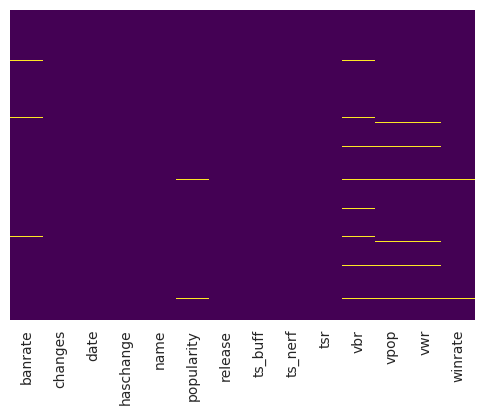

In [135]:
#Check NaNs
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
df2.info()

In [136]:
df2.dropna(inplace=True)
df2 = df2.drop(df2[df2['winrate']==0].index)


In [188]:
df.to_csv('loldata_cleaned.csv', index=False)

In [137]:
df2.to_csv('loldata_cleaned_v2.csv', index=False)

In [171]:
df.groupby('changes').count()

,date,popularity,winrate,banrate,name,release,tsr,haschange,ts_nerf,ts_buff
changes,,,,,,,,,,
buff,665,665,665,665,665,665,665,665,665,665
nerf,589,589,589,589,589,589,589,589,589,589
nochange,15218,15218,15218,15218,15218,15218,15218,15218,15218,15218


In [68]:
df.groupby('changes').describe()['vpop']

changes        
buff      count      645.000000
          mean        -0.187597
          std          2.416888
          min        -15.150000
          25%         -0.510000
          50%         -0.040000
          75%          0.220000
          max         17.110000
nerf      count      576.000000
          mean         0.038125
          std          2.988756
          min        -12.840000
          25%         -1.140000
          50%         -0.120000
          75%          0.660000
          max         26.650000
nochange  count    14996.000000
          mean        -0.002766
          std          1.573771
          min        -19.180000
          25%         -0.390000
          50%         -0.030000
          75%          0.280000
          max         17.990000
Name: vpop, dtype: float64

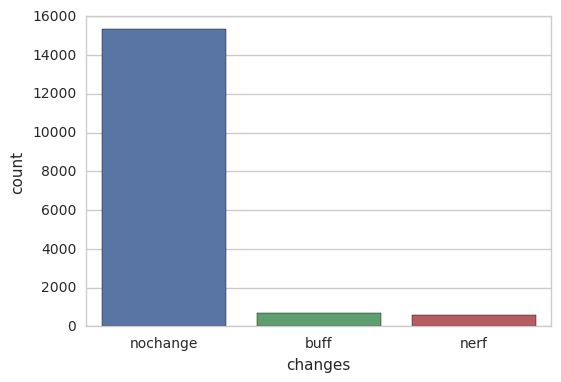

In [79]:
sns.set_style('whitegrid')
sns.countplot(x='changes',data=df, )

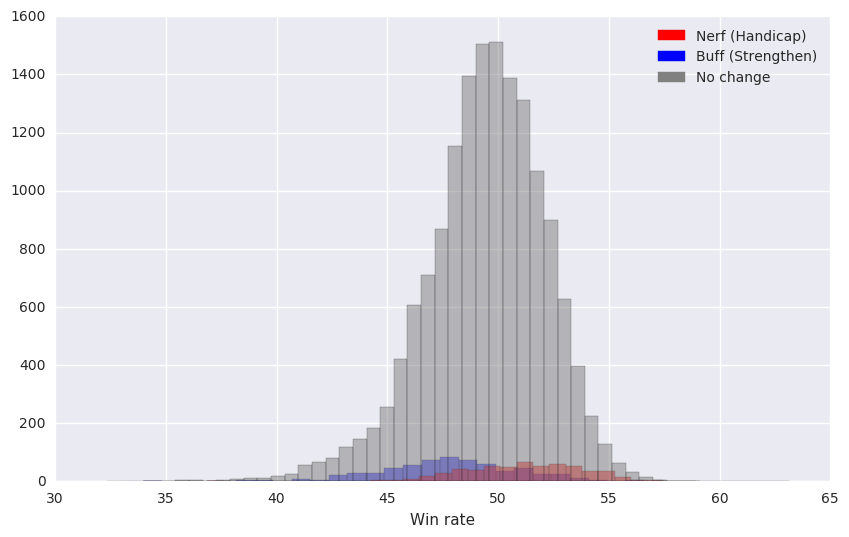

In [18]:
import matplotlib.patches as mpatches
plt.figure(figsize=(10,6))
plt.xlabel('Win rate')
df[df['changes']=='buff']['winrate'].hist(alpha=0.5,color='blue',
                                              bins=30,label='buff')
df[df['changes']=='nerf']['winrate'].hist(alpha=0.5,color='red',
                                              bins=30,label='nerf')
df[df['changes']=='nochange']['winrate'].hist(alpha=0.5,color='grey',
                                              bins=50,label='nerf')
red_patch = mpatches.Patch(color='red', label='Nerf (Handicap)')
blue_patch = mpatches.Patch(color='blue', label='Buff (Strengthen)')
grey_patch = mpatches.Patch(color='grey', label='No change')
plt.legend(handles=[red_patch, blue_patch, grey_patch])

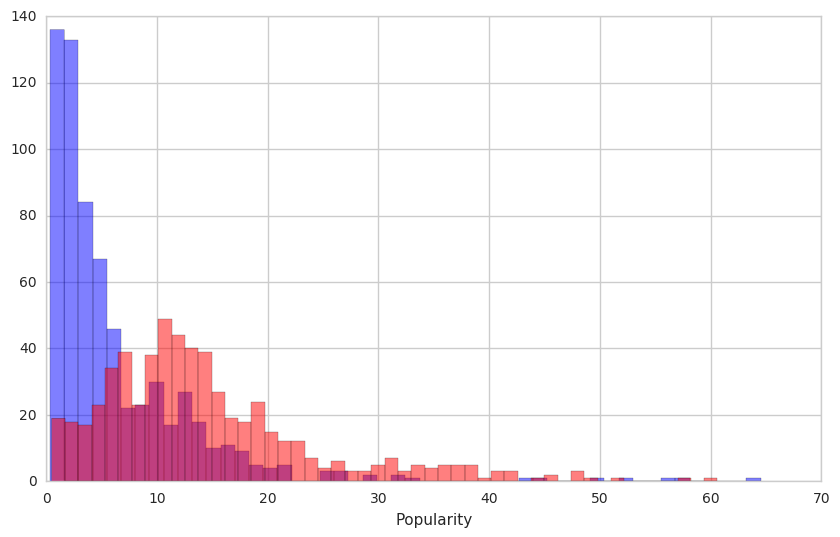

In [139]:
plt.figure(figsize=(10,6))
plt.xlabel('Popularity')
df[df['changes']=='buff']['popularity'].hist(alpha=0.5,color='blue',
                                              bins=50,label='buff')
df[df['changes']=='nerf']['popularity'].hist(alpha=0.5,color='red',
                                              bins=50,label='nerf')
# df[df['changes']=='nochange']['popularity'].hist(alpha=0.5,color='grey',
#                                               bins=50,label='nerf')

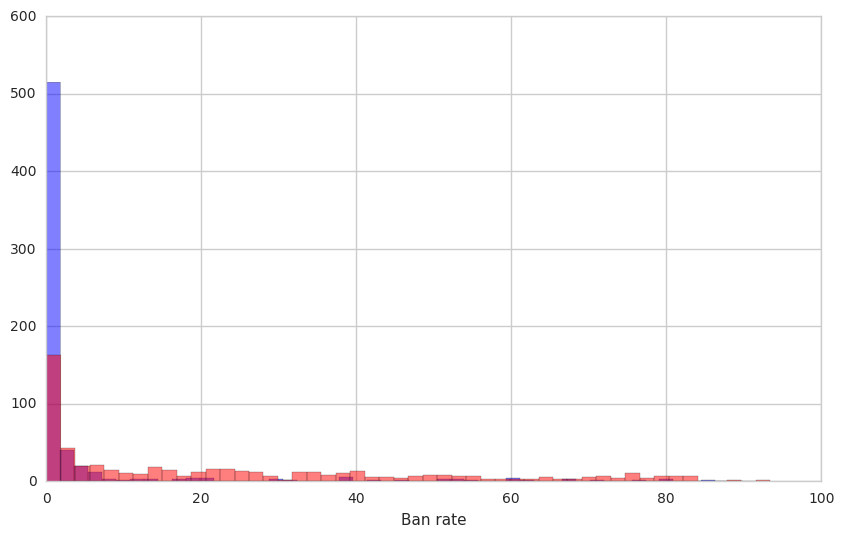

In [140]:
plt.figure(figsize=(10,6))
plt.xlabel('Ban rate')
df[df['changes']=='buff']['banrate'].hist(alpha=0.5,color='blue',
                                              bins=50,label='buff')
df[df['changes']=='nerf']['banrate'].hist(alpha=0.5,color='red',
                                              bins=50,label='nerf')
# df[df['changes']=='nochange']['popularity'].hist(alpha=0.5,color='grey',
#                                               bins=50,label='nerf')

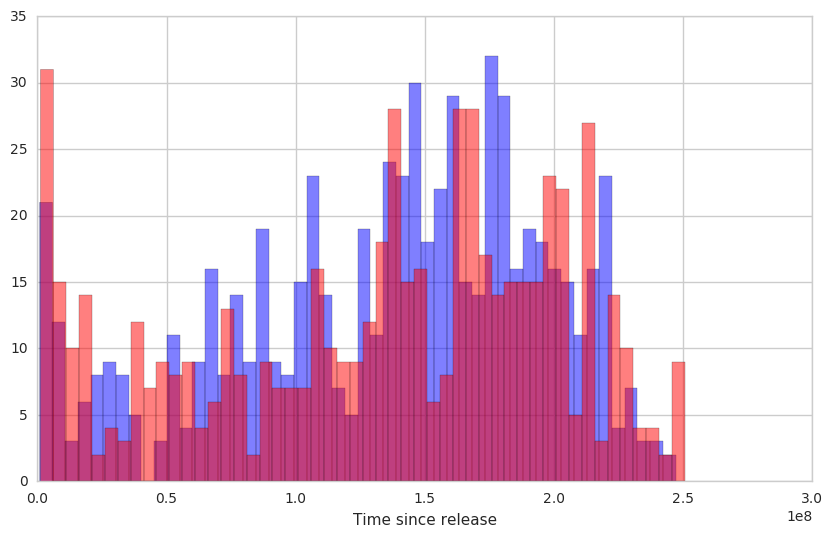

In [146]:
plt.figure(figsize=(10,6))
plt.xlabel('Time since release')
df[df['changes']=='buff']['tsr'].hist(alpha=0.5,color='blue',
                                              bins=50,label='buff')
df[df['changes']=='nerf']['tsr'].hist(alpha=0.5,color='red',
                                              bins=50,label='nerf')
# df[df['changes']=='nochange']['tsr'].hist(alpha=0.5,color='grey',
#                                               bins=50,label='tsr')

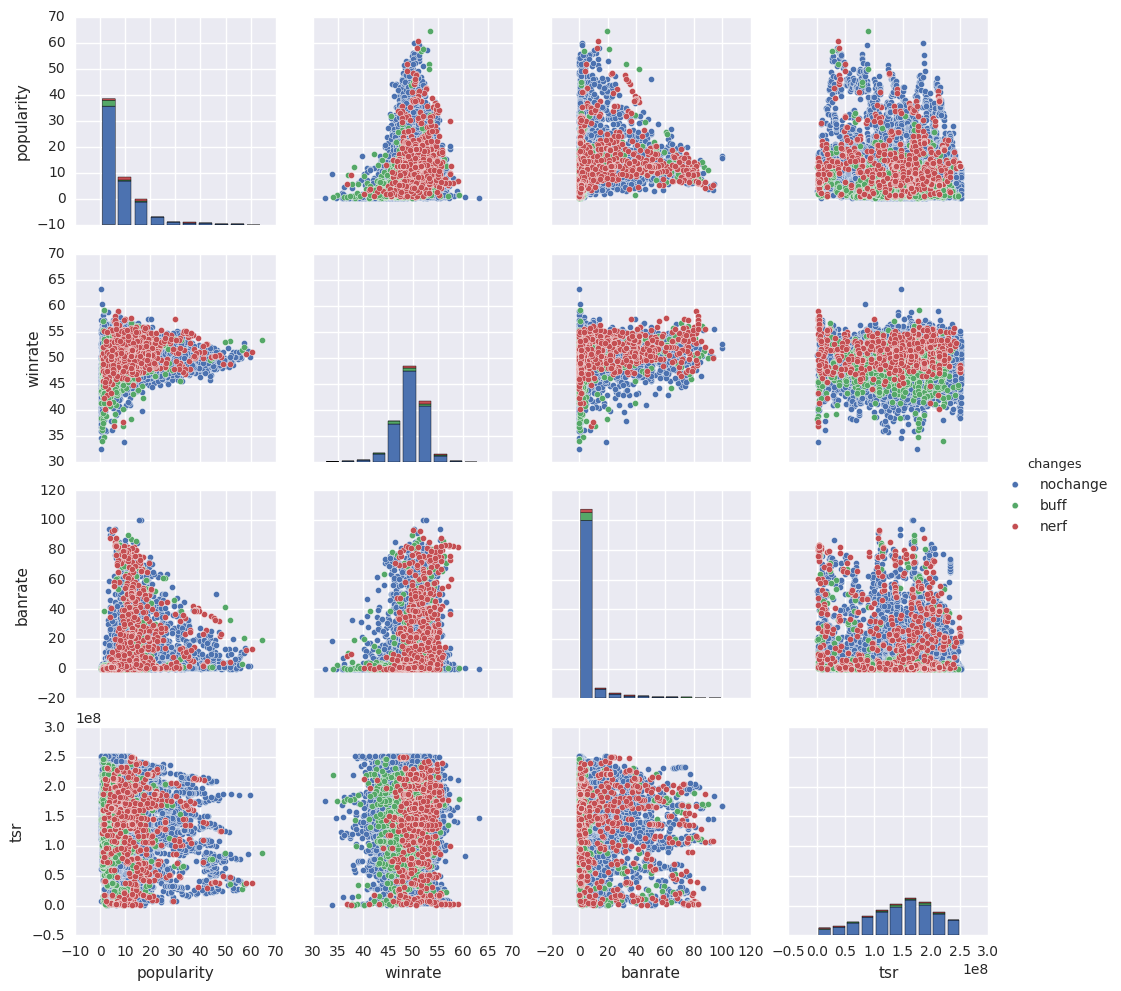

In [95]:
sns.pairplot(df[['popularity', 'winrate', 'banrate', 'changes', 'tsr']], hue="changes")

In [138]:
df2.head()

,banrate,changes,date,freq_buff,freq_nerf,haschange,name,popularity,release,ts_buff,ts_nerf,tsr,vbr,vpop,vwr,winrate
1,0.13,nochange,1.395140e+09,5.0,5.0,False,aatrox,4.34,1.370045e+09,25.0,25.0,2.509560e+07,-0.31,-0.04,-2.02,49.72
2,0.19,nochange,1.395767e+09,21.0,16.0,False,aatrox,4.80,1.370045e+09,25.0,25.0,2.572200e+07,0.06,0.46,1.13,50.85
3,0.28,nochange,1.396411e+09,18.0,14.0,False,aatrox,5.06,1.370045e+09,25.0,25.0,2.636640e+07,0.09,0.26,0.03,50.88
4,0.20,nochange,1.397171e+09,14.0,18.0,False,aatrox,4.53,1.370045e+09,25.0,25.0,2.712601e+07,-0.08,-0.53,-1.40,49.48
5,0.34,nochange,1.397808e+09,14.0,16.0,False,aatrox,4.53,1.370045e+09,25.0,25.0,2.776320e+07,0.14,0.00,1.71,51.19


# Split hold out set


In [5]:
df = pd.read_csv('loldata_cleaned.csv')

In [148]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
features = df2[['popularity', 'winrate', 'banrate', 'tsr', 'ts_buff',
              'ts_nerf']]
# features = df[['popularity', 'winrate', 'banrate']]

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    df2['changes'], test_size=0.25, 
                                                    random_state=RANDOM_STATE)

In [181]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(features, 
                                                    df['haschange'],test_size=0.25, 
                                                    random_state=RANDOM_STATE)

In [49]:
df[df['name']=='leesin']

,banrate,changes,date,haschange,name,popularity,release,ts_buff,ts_nerf,tsr,vbr,vpop,vwr,winrate
1,13.47,nochange,1.395140e+09,False,leesin,49.91,1.270080e+09,25.0,25.0,1.250604e+08,0.50,-1.36,-0.27,49.40
2,22.30,nerf,1.395767e+09,True,leesin,47.82,1.270080e+09,25.0,25.0,1.256868e+08,8.83,-2.09,1.12,50.52
3,23.15,nerf,1.396411e+09,True,leesin,48.27,1.270080e+09,1.0,25.0,1.263312e+08,0.85,0.45,-0.49,50.03
4,15.91,nochange,1.397171e+09,False,leesin,30.65,1.270080e+09,1.0,25.0,1.270908e+08,-7.24,-17.62,-3.68,46.35
5,9.44,nochange,1.397808e+09,False,leesin,29.57,1.270080e+09,2.0,25.0,1.277280e+08,-6.47,-1.08,0.87,47.22
6,6.24,nochange,1.398488e+09,False,leesin,34.07,1.270080e+09,3.0,25.0,1.284084e+08,-3.20,4.50,0.99,48.21
7,5.57,nochange,1.399322e+09,False,leesin,39.52,1.270080e+09,4.0,25.0,1.292423e+08,-0.67,5.45,-1.07,47.14
8,10.96,nochange,1.399928e+09,False,leesin,45.87,1.270080e+09,5.0,25.0,1.298484e+08,5.39,6.35,2.36,49.50
9,50.00,nochange,1.400560e+09,False,leesin,46.18,1.270080e+09,6.0,25.0,1.304799e+08,39.04,0.31,0.45,49.95
10,0.00,nochange,1.401192e+09,False,leesin,48.15,1.270080e+09,7.0,25.0,1.311117e+08,-50.00,1.97,-0.47,49.48


# Under/over sample

Undersampling better thank oversampling  
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.68.6858&rep=rep1&type=pdf

Near miss 2 best undersampling  
http://sci2s.ugr.es/keel/pdf/algorithm/congreso/2006-Yen-ICIC.pdf


Comparison of methods  
http://www.ulb.ac.be/di/map/adalpozz/pdf/poster_unbalanced.pdf  
SMOTE + ENN or Tomek best combo


# Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression
model_logreg = LogisticRegression(class_weight='balanced')
model_logreg.fit(X_train,y_train)

p_log = model_logreg.predict(X_test)


print(classification_report(y_test,p_log))

             precision    recall  f1-score   support

       buff       0.00      0.00      0.00       143
       nerf       0.00      0.00      0.00       137
   nochange       0.93      1.00      0.96      3775

avg / total       0.87      0.93      0.90      4055



/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [182]:
# Predict has change (2 class)
model_logreg.fit(X_train2,y_train2)

p_log = model_logreg.predict(X_test2)


print(classification_report(y_test2,p_log))

ValueError: Unknown label type: 'unknown'

In [66]:
# Use undersampling
from imblearn.under_sampling import NearMiss
from imblearn import pipeline as pl
from imblearn.metrics import classification_report_imbalanced

RANDOM_STATE = 42

pipe_logreg = pl.make_pipeline(NearMiss(version=2, random_state=RANDOM_STATE),
                            LogisticRegression(random_state=RANDOM_STATE))

pipe_logreg.fit(X_train2, y_train2)
p_logreg_nm2 = pipe_logreg.predict(X_test2)
print(classification_report_imbalanced(y_test2, p_logreg_nm2))

                   pre       rec       spe        f1       geo       iba       sup

      False       0.00      0.00      1.00      0.00      0.00      0.00      3840
       True       0.07      1.00      0.00      0.14      0.00      0.00       307

avg / total       0.01      0.07      0.93      0.01      0.00      0.00      4147



/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.5/site-packages/imblearn/metrics/classification.py:238: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples.
  warn_for)
/opt/conda/lib/python3.5/site-packages/imblearn/metrics/classification.py:238: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples.
  warn_for)
/opt/conda/lib/python3.5/site-packages/imblearn/metrics/classification.py:238: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples.
  warn_for)
/opt/conda/lib/python3.5/site-packages/imblearn/metrics/classification.py:240: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in 

In [67]:
# Use over + under sampling
from imblearn.combine import SMOTETomek
from imblearn import pipeline as pl
from imblearn.metrics import classification_report_imbalanced

RANDOM_STATE = 42

pipe_logreg = pl.make_pipeline(SMOTETomek(random_state=RANDOM_STATE),
                            LogisticRegression(random_state=RANDOM_STATE))

pipe_logreg.fit(X_train2, y_train2)
p_logreg_nm2 = pipe_logreg.predict(X_test2)
print(classification_report_imbalanced(y_test2, p_logreg_nm2))

                   pre       rec       spe        f1       geo       iba       sup

      False       0.93      1.00      0.00      0.96      0.00      0.00      3840
       True       0.00      0.00      1.00      0.00      0.00      0.00       307

avg / total       0.86      0.93      0.07      0.89      0.00      0.00      4147



/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.5/site-packages/imblearn/metrics/classification.py:238: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples.
  warn_for)
/opt/conda/lib/python3.5/site-packages/imblearn/metrics/classification.py:238: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples.
  warn_for)
/opt/conda/lib/python3.5/site-packages/imblearn/metrics/classification.py:238: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples.
  warn_for)
/opt/conda/lib/python3.5/site-packages/imblearn/metrics/classification.py:240: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in 

# K-NN

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(features)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [27]:
scaled_features = scaler.transform(features)
df_scaled = pd.DataFrame(scaled_features, 
                         columns=['popularity', 'winrate', 'banrate', 'tsr'])
df_scaled.head()

,popularity,winrate,banrate,tsr
0,-0.443214,0.831948,-0.346817,-2.064366
1,-0.331187,0.720566,-0.358786,0.269370
2,-0.810075,-1.280714,-0.369958,-1.615627
3,-0.546625,1.033154,-0.323675,-0.087849
4,-0.771911,0.584034,-0.369958,0.182280


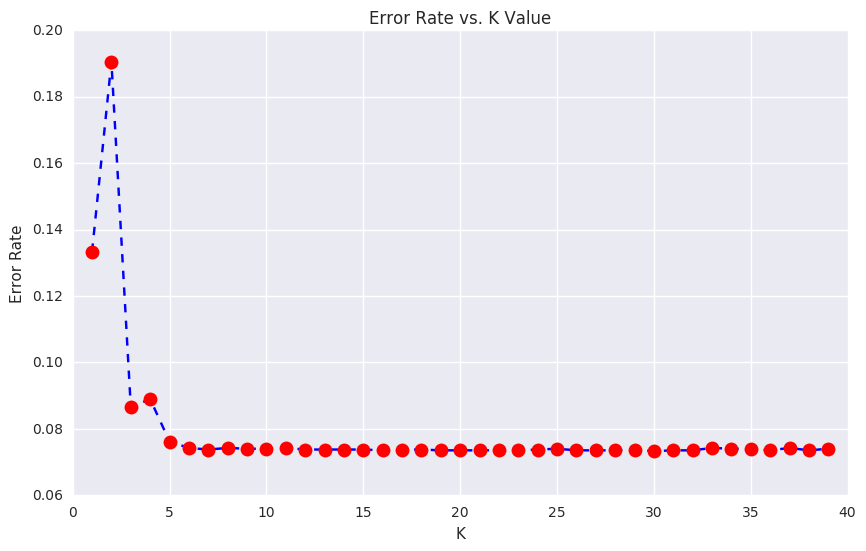

In [32]:
from sklearn.neighbors import KNeighborsClassifier
error_rate = []

# Will take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [34]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train,y_train)
p_knn = knn.predict(X_test)
print(classification_report(y_test,p_knn))

             precision    recall  f1-score   support

       buff       0.05      0.10      0.06       157
       nerf       0.09      0.15      0.11       150
   nochange       0.93      0.86      0.90      3840

avg / total       0.87      0.81      0.84      4147



In [33]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train2,y_train2)
p_knn = knn.predict(X_test2)
print(classification_report(y_test2,p_knn))

             precision    recall  f1-score   support

      False       0.93      0.99      0.96      3840
       True       0.20      0.02      0.03       307

avg / total       0.87      0.92      0.89      4147



In [65]:
# Use undersampling
from imblearn.under_sampling import NearMiss
from imblearn import pipeline as pl
from imblearn.metrics import classification_report_imbalanced

RANDOM_STATE = 42

pipe_knn = pl.make_pipeline(NearMiss(version=2, random_state=RANDOM_STATE),
                            KNeighborsClassifier(n_neighbors=5))

pipe_knn.fit(X_train2, y_train2)
p_knn_nm2 = pipe_knn.predict(X_test2)
print(classification_report_imbalanced(y_test2, p_knn_nm2))

                   pre       rec       spe        f1       geo       iba       sup

      False       0.96      0.08      0.96      0.15      0.27      0.08      3840
       True       0.08      0.96      0.08      0.14      0.27      0.07       307

avg / total       0.90      0.15      0.89      0.15      0.27      0.08      4147



In [159]:
# Use over + under sampling
from imblearn.combine import SMOTETomek
from imblearn import pipeline as pl
from imblearn.metrics import classification_report_imbalanced

RANDOM_STATE = 42

pipe_knn = pl.make_pipeline(SMOTETomek(random_state=RANDOM_STATE),
                            KNeighborsClassifier(n_neighbors=5))

pipe_knn.fit(X_train, y_train)
p_knn_nm2 = pipe_knn.predict(X_test)
print(classification_report_imbalanced(y_test, p_knn_nm2))

/opt/conda/lib/python3.5/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/opt/conda/lib/python3.5/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/opt/conda/lib/python3.5/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


                   pre       rec       spe        f1       geo       iba       sup

       buff       0.00      0.00      1.00      0.00      0.00      0.00       157
       nerf       0.05      0.35      0.73      0.08      0.21      0.04       150
   nochange       0.93      0.73      0.35      0.82      0.29      0.09      3840

avg / total       0.87      0.69      0.38      0.76      0.28      0.09      4147



# Decision Tree

In [70]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(class_weight='balanced')
dtree.fit(X_train,y_train)

predictions = dtree.predict(X_test)
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

       buff       0.34      0.34      0.34       143
       nerf       0.33      0.35      0.34       137
   nochange       0.95      0.95      0.95      3775

avg / total       0.91      0.91      0.91      4055



In [ ]:
dtree.fit(X_train2,y_train2)

p_dtree = dtree.predict(X_test2)
print(classification_report(y_test2,p_dtree))

In [5]:
# Use over + under sampling
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn import pipeline as pl
from imblearn.metrics import classification_report_imbalanced

RANDOM_STATE = 42

pipe_dtree = pl.make_pipeline(SMOTETomek(random_state=RANDOM_STATE),
                            DecisionTreeClassifier())

pipe_dtree.fit(X_train, y_train)
p_rf_nm2 = pipe_dtree.predict(X_test)
print(classification_report_imbalanced(y_test, p_rf_nm2))

/opt/conda/lib/python3.5/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/opt/conda/lib/python3.5/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/opt/conda/lib/python3.5/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


                   pre       rec       spe        f1       geo       iba       sup

       buff       0.25      0.30      0.97      0.27      0.49      0.23       146
       nerf       0.19      0.43      0.93      0.26      0.43      0.17       150
   nochange       0.95      0.89      0.40      0.92      0.46      0.23      3822

avg / total       0.90      0.86      0.43      0.87      0.46      0.22      4118



# XGBoost 

In [211]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4


y_train = pd.DataFrame(data=y_train)
y_train = y_train.astype('category')
y_train_dummy = y_train.apply(lambda x: x.cat.codes)

def modelfit(alg, dtrain, target, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    param = {}
    # use softmax multi-class classification
    param['objective'] = 'multi:softmax'
    # scale weight of positive examples
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['silent'] = 1
    param['nthread'] = 4
    param['num_class'] = 3
    
    if useTrainCV:
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=target)
        cvresult = xgb.cv(param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], y_train_dummy ,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

predictors = X_train.columns
xgb1 = XGBClassifier()
modelfit(xgb1, X_train, y_train_dummy.values, predictors)

XGBoostError: b'[07:17:44] src/metric/rank_metric.cc:88: Check failed: (preds.size()) == (info.labels.size()) label size predict size not match'

In [225]:
y_test = pd.DataFrame(data=y_test)
y_test = y_train.astype('category')
y_test_dummy = y_test.apply(lambda x: x.cat.codes)

y_train = pd.DataFrame(data=y_train)
y_train = y_train.astype('category')
y_train_dummy = y_train.apply(lambda x: x.cat.codes)

xg_train = xgb.DMatrix( X_train, label=y_train_dummy)
xg_test = xgb.DMatrix(X_test, label=y_test_dummy)


# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 4

watchlist = [ (xg_train,'train'), (xg_test, 'test') ]
num_round = 5
bst = xgb.train(param, xg_train, num_round, watchlist );
# get prediction
pred = bst.predict( xg_test );

print ('predicting, classification error=%f' % (sum( int(pred[i]) != test_Y[i] for i in range(len(test_Y))) / float(len(test_Y)) ))


Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f97fdda3be0>>
Traceback (most recent call last):
  File "/home/jovyan/work/xgboost/python-package/xgboost/core.py", line 337, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'
Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f97f8016828>>
Traceback (most recent call last):
  File "/home/jovyan/work/xgboost/python-package/xgboost/core.py", line 337, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'


XGBoostError: b'[07:25:02] src/metric/multiclass_metric.cc:27: Check failed: preds.size() % info.labels.size() == 0 label and prediction size not match'

In [ ]:
X_te

In [149]:
xgbc = xgb.XGBClassifier()
xgbc.fit(X_train, y_train)
p_xgb = xgbc.predict(X_test)

print(classification_report(y_test, p_xgb))

             precision    recall  f1-score   support

       buff       0.59      0.31      0.40       143
       nerf       0.63      0.29      0.40       137
   nochange       0.95      0.99      0.97      3775

avg / total       0.93      0.94      0.93      4055



In [41]:
# Use undersampling
from imblearn.under_sampling import EditedNearestNeighbours, NearMiss, TomekLinks
from imblearn import pipeline as pl
from imblearn.metrics import classification_report_imbalanced

RANDOM_STATE = 42

xgb = xgboost.XGBClassifier()
pipe_xgb = pl.make_pipeline(EditedNearestNeighbours(n_neighbors=10,
                            kind_sel = 'mode',
                            random_state=RANDOM_STATE),
                            xgb)

# pipe_xgb = pl.make_pipeline(NearMiss(ratio=0.05, version=2, 
#                             random_state=RANDOM_STATE),
#                             xgb)

# pipe_xgb = pl.make_pipeline(TomekLinks(random_state=RANDOM_STATE),
#                             xgb)

pipe_xgb.fit(X_train, y_train)

p_xgb_u = pipe_xgb.predict(X_test.as_matrix())


print(classification_report_imbalanced(y_test, p_xgb_u))

/opt/conda/lib/python3.5/site-packages/scipy/stats/stats.py:250: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


                   pre       rec       spe        f1       geo       iba       sup

       buff       0.00      0.00      1.00      0.00      0.00      0.00       143
       nerf       0.71      0.42      0.99      0.53      0.83      0.67       137
   nochange       0.94      0.99      0.21      0.97      0.82      0.68      3775

avg / total       0.90      0.94      0.26      0.92      0.79      0.66      4055



/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.5/site-packages/imblearn/metrics/classification.py:240: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples.
  average, warn_for)


In [154]:
# Use oversampling
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn import pipeline as pl
from imblearn.metrics import classification_report_imbalanced

RANDOM_STATE = 42

xgb = xgboost.XGBClassifier()
pipe_xgb = pl.make_pipeline(SMOTE(kind='borderline1', random_state=RANDOM_STATE),
                            xgb)


pipe_xgb.fit(X_train, y_train)

p_xgb_o = pipe_xgb.predict(X_test.as_matrix())


print(classification_report_imbalanced(y_test, p_xgb_o))

/opt/conda/lib/python3.5/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


                   pre       rec       spe        f1       geo       iba       sup

       buff       0.57      0.33      0.99      0.42      0.75      0.54       143
       nerf       0.22      0.67      0.92      0.33      0.46      0.20       137
   nochange       0.96      0.91      0.53      0.93      0.53      0.30      3775

avg / total       0.92      0.88      0.56      0.90      0.54      0.31      4055



In [156]:
y_test

91     nochange
126    nochange
91     nochange
2      nochange
125    nochange
109    nochange
2          nerf
35     nochange
80         buff
70     nochange
60     nochange
32     nochange
133    nochange
58     nochange
19         buff
130    nochange
80     nochange
40     nochange
92     nochange
62     nochange
38     nochange
128        nerf
90     nochange
128    nochange
58     nochange
75     nochange
11     nochange
96     nochange
106    nochange
110    nochange
         ...   
92         nerf
129    nochange
83     nochange
72     nochange
7      nochange
86     nochange
78     nochange
55     nochange
67     nochange
17         nerf
91     nochange
6      nochange
102    nochange
65     nochange
124    nochange
68     nochange
38     nochange
76     nochange
40     nochange
19     nochange
84     nochange
66     nochange
74     nochange
28     nochange
36     nochange
32     nochange
36         nerf
74     nochange
19     nochange
116    nochange
Name: changes, dtype: ob

In [155]:
print(X_train.columns)
xgb.feature_importances_

Index(['popularity', 'winrate', 'banrate', 'tsr', 'ts_buff', 'ts_nerf'], dtype='object')


array([ 0.13269231,  0.19711539,  0.13557692,  0.25769231,  0.14471154,
        0.13221154], dtype=float32)

In [21]:
# Use over + under sampling
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn import pipeline as pl
from imblearn.metrics import classification_report_imbalanced

RANDOM_STATE = 42

xgb = xgboost.XGBClassifier()
smote = SMOTE(kind='borderline1', random_state=RANDOM_STATE)

# pipe_xgb = pl.make_pipeline(SMOTETomek(random_state=RANDOM_STATE,
#                             smote=smote),
#                             xgb)

pipe_xgb = pl.make_pipeline(SMOTEENN(random_state=RANDOM_STATE,
                            smote=smote),
                            xgb)


pipe_xgb.fit(X_train, y_train)

p_xgb_o = pipe_xgb.predict(X_test.as_matrix())


print(classification_report_imbalanced(y_test, p_xgb_o))

/opt/conda/lib/python3.5/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/opt/conda/lib/python3.5/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


                   pre       rec       spe        f1       geo       iba       sup

       buff       0.52      0.41      0.99      0.46      0.71      0.49       146
       nerf       0.21      0.53      0.92      0.30      0.46      0.19       150
   nochange       0.96      0.91      0.50      0.93      0.53      0.30      3822

avg / total       0.92      0.88      0.53      0.89      0.54      0.31      4118



# Random forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_features='auto',
                             n_estimators=128,
                             class_weight='balanced', 
                             min_samples_leaf=50)
# rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
p_rfc = rfc.predict(X_test)
print(classification_report(y_test, p_rfc))

             precision    recall  f1-score   support

       buff       0.34      0.55      0.42       146
       nerf       0.25      0.76      0.38       150
   nochange       0.97      0.87      0.92      3822

avg / total       0.92      0.86      0.88      4118



In [186]:
# Use undersampling
from imblearn.under_sampling import NearMiss, TomekLinks, EditedNearestNeighbours
from imblearn import pipeline as pl
from imblearn.metrics import classification_report_imbalanced

RANDOM_STATE = 42


pipe_rf = pl.make_pipeline(NearMiss(version=2,
                                    ratio=0.1,
                                    random_state=RANDOM_STATE),
                            RandomForestClassifier(max_features='auto',
                             n_estimators=128, 
                             min_samples_leaf=50))

# pipe_rf = pl.make_pipeline(EditedNearestNeighbours(n_neighbors=5,
#                                     random_state=RANDOM_STATE),
#                             RandomForestClassifier(max_features='auto',
#                              n_estimators=128, 
#                              min_samples_leaf=50))

pipe_rf.fit(X_train, y_train)
p_rf_nm2 = pipe_rf.predict(X_test)
print(classification_report_imbalanced(y_test, p_rf_nm2))

/opt/conda/lib/python3.5/site-packages/imblearn/under_sampling/nearmiss.py:209: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn('The number of the samples to be selected is larger'


                   pre       rec       spe        f1       geo       iba       sup

       buff       0.06      0.75      0.59      0.12      0.25      0.06       146
       nerf       0.12      0.68      0.81      0.20      0.34      0.11       150
   nochange       0.96      0.38      0.78      0.55      0.29      0.09      3822

avg / total       0.90      0.41      0.77      0.52      0.29      0.09      4118



In [34]:
# Use oversampling
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn import pipeline as pl
from imblearn.metrics import classification_report_imbalanced

RANDOM_STATE = 42

rfc = RandomForestClassifier(max_features='auto',
                            n_estimators=128, 
                            min_samples_leaf=1)

pipe_rf = pl.make_pipeline(SMOTE(kind='borderline1', random_state=RANDOM_STATE),
                            rfc)

# pipe_rf = pl.make_pipeline(ADASYN(),
#                             RandomForestClassifier(max_features='auto',
#                              n_estimators=128, 
#                              min_samples_leaf=50))

pipe_rf.fit(X_train, y_train)
p_rf_o = pipe_rf.predict(X_test)
print(classification_report_imbalanced(y_test, p_rf_o))

/opt/conda/lib/python3.5/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


                   pre       rec       spe        f1       geo       iba       sup

       buff       0.61      0.26      0.99      0.37      0.77      0.58       146
       nerf       0.41      0.49      0.97      0.45      0.63      0.38       150
   nochange       0.95      0.97      0.40      0.96      0.68      0.48      3822

avg / total       0.92      0.92      0.44      0.92      0.68      0.48      4118



In [97]:
# import pickle
from sklearn.externals import joblib
joblib.dump(rfc, 'rfc_o.pkl', compress=9)


['rfc_o.pkl']

In [12]:
from sklearn.externals import joblib
import pandas as pd

def predict():
    df = pd.read_csv('lolcurrent.csv')
    pickled_rfc = joblib.load('rfc_o.pkl')
    p_current_prob = pickled_rfc.predict_proba(df[['popularity', 'winrate','banrate', 'tsr']])
    p_current = pickled_rfc.predict(df[['popularity', 'winrate','banrate', 'tsr']])
    df_current['changes'] = p_current
    df_current['buffp'] = p_current_prob[:,0]
    df_current['nochangep'] = p_current_prob[:,2]
    df_current['nerfp'] = p_current_prob[:,1]
    df_current['nochangep'] = p_current_prob[:,2]
    changes = df_current[df_current['changes']=='nerf']
    data = changes.to_html()
    print(data)
predict()

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>name</th>
      <th>popularity</th>
      <th>winrate</th>
      <th>banrate</th>
      <th>release</th>
      <th>tsr</th>
      <th>changes</th>
      <th>buffp</th>
      <th>nochangep</th>
      <th>nerfp</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>36</th>
      <td>darius</td>
      <td>9.7</td>
      <td>51.7</td>
      <td>9.8</td>
      <td>1.335830e+09</td>
      <td>149651831.0</td>
      <td>nerf</td>
      <td>0.03125</td>
      <td>0.453125</td>
      <td>0.515625</td>
    </tr>
  </tbody>
</table>


In [7]:
table = '<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>name</th>\n      <th>popularity</th>\n      <th>winrate</th>\n      <th>banrate</th>\n      <th>release</th>\n      <th>tsr</th>\n      <th>changes</th>\n      <th>buffp</th>\n      <th>nochangep</th>\n      <th>nerfp</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>36</th>\n      <td>darius</td>\n      <td>9.7</td>\n      <td>51.7</td>\n      <td>9.8</td>\n      <td>1.335830e+09</td>\n      <td>149651831.0</td>\n      <td>nerf</td>\n      <td>0.03125</td>\n      <td>0.453125</td>\n      <td>0.515625</td>\n    </tr>\n  </tbody>\n</table>'

In [93]:
# df_current[df_current['changes']='nerf']
df_current[df_current['winrate']<50]

,name,popularity,winrate,banrate,release,tsr,changes
0,leesin,34.6,49.1,10.7,1.270080e+09,215402231.0,nochange
1,ezreal,32.9,48.8,0.2,1.267402e+09,218080631.0,nochange
13,vayne,15.7,49.4,6.1,1.304208e+09,181274231.0,nochange
14,yasuo,15.5,48.4,19.8,1.385856e+09,99626231.0,nochange
15,karma,15.3,48.3,0.2,1.296518e+09,188963831.0,nochange
16,orianna,15.0,47.9,0.6,1.306886e+09,178595831.0,nochange
18,ashe,14.8,48.0,0.1,1.233446e+09,252035831.0,nochange
20,missfortune,13.4,48.3,0.2,1.283299e+09,202183031.0,nochange
21,fiora,13.4,49.5,4.3,1.328054e+09,157427831.0,nochange
22,elise,13.2,48.7,2.4,1.349050e+09,136432631.0,nochange


In [76]:
print(features.columns)
print(rfc.feature_importances_)

Index(['popularity', 'winrate', 'banrate', 'tsr'], dtype='object')
[ 0.20223601  0.12497353  0.38454511  0.28824535]


In [70]:
# Use over + under sampling
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn import pipeline as pl
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42

rfc = RandomForestClassifier(max_features='auto',
                            n_estimators=64)
smote = SMOTE(kind='borderline1', random_state=RANDOM_STATE)

pipe_rf = pl.make_pipeline(SMOTEENN(smote=smote, random_state=RANDOM_STATE),
                            rfc)

pipe_rf.fit(X_train, y_train)
p_rf_ou = pipe_rf.predict(X_test)
print(classification_report_imbalanced(y_test, p_rf_ou))

/opt/conda/lib/python3.5/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/opt/conda/lib/python3.5/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


                   pre       rec       spe        f1       geo       iba       sup

       buff       0.39      0.08      1.00      0.13      0.61      0.35       157
       nerf       0.27      0.42      0.96      0.33      0.51      0.24       150
   nochange       0.94      0.95      0.28      0.95      0.55      0.32      3840

avg / total       0.90      0.90      0.33      0.89      0.55      0.32      4147



# SVM

In [54]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [15]:
p_svm = svm.predict(X_test)
print(classification_report(y_test, p_svm))

             precision    recall  f1-score   support

       buff       0.00      0.00      0.00       157
       nerf       0.00      0.00      0.00       150
   nochange       0.93      1.00      0.96      3840

avg / total       0.86      0.93      0.89      4147



/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [160]:
# Use oversampling
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn import pipeline as pl
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}
RANDOM_STATE = 42

pipe_rf = pl.make_pipeline(SMOTE(kind='svm', random_state=RANDOM_STATE),
                            GridSearchCV(SVC(),param_grid,refit=True,verbose=0))

# pipe_rf = pl.make_pipeline(ADASYN(),
#                             RandomForestClassifier(max_features='auto',
#                              n_estimators=128, 
#                              min_samples_leaf=50))

pipe_rf.fit(X_train, y_train)
p_rf_nm2 = pipe_rf.predict(X_test)
print(classification_report_imbalanced(y_test, p_rf_nm2))


/opt/conda/lib/python3.5/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


                   pre       rec       spe        f1       geo       iba       sup

       buff       0.03      0.01      0.98      0.02      0.17      0.03       157
       nerf       0.08      0.05      0.98      0.06      0.28      0.07       150
   nochange       0.93      0.96      0.05      0.94      0.29      0.09      3840

avg / total       0.86      0.89      0.11      0.88      0.29      0.09      4147



In [24]:
grid.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [161]:
grid.best_params_

NameError: name 'grid' is not defined

In [25]:
grid_predictions = grid.predict(X_test)
print(classification_report(y_test,grid_predictions))

             precision    recall  f1-score   support

       buff       0.33      0.01      0.01       157
       nerf       0.00      0.00      0.00       150
   nochange       0.93      1.00      0.96      3840

avg / total       0.87      0.93      0.89      4147



/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
